In [1]:
import pandas as pd
from scipy import stats
import joblib

## データの読み込み

In [2]:
mail_df = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

In [3]:
mail_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [4]:
mail_df.shape

(64000, 12)

## (4) データの準備
### 女性向けメールが配信されたデータを削除したデータを作成

In [5]:
male_df = mail_df[mail_df.segment != 'Womens E-Mail'].copy() # 女性向けメールが配信されたデータを削除
male_df['treatment'] = male_df.segment.apply(lambda x: 1 if x == 'Mens E-Mail' else 0) #介入を表すtreatment変数を追加

In [6]:
male_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0


In [7]:
male_df.shape

(42613, 13)

## (5) 集計による比較
### group_byとsummairseを使って集計

In [8]:
male_df.groupby('treatment').agg( # データのグループ化
    conversion_rate=('conversion', 'mean'), # グループごとのconversionの平均
    spend_mean=('spend', 'mean'), # グループごとのspendの平均
    count=('treatment', 'count') # グループごとのデータ数
)

,conversion_rate,spend_mean,count
treatment,,,
0,0.005726,0.652789,21306
1,0.012531,1.422617,21307


## (6) t検定を行う

In [9]:
### (a)男性向けメールが配信されたグループの購買データを得る
mens_mail = male_df[male_df.treatment==1].spend.values

### (b)メールが配信されなかったグループの購買データを得る
no_mail = male_df[male_df.treatment==0].spend.values

### (a)(b)の平均の差に対して有意差検定を実行する
stats.ttest_ind(mens_mail, no_mail)

Ttest_indResult(statistic=5.300090294465472, pvalue=1.163200872605869e-07)

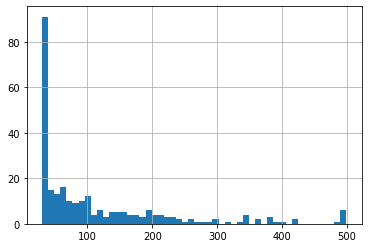

In [30]:
male_df[(male_df['treatment']==1) & (male_df['spend']!=0)]['spend'].hist(bins=50)

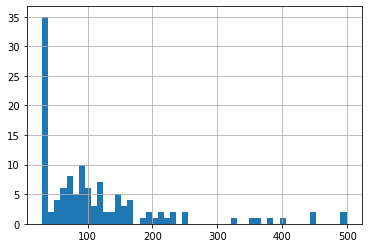

In [31]:
male_df[(male_df['treatment']==0) & (male_df['spend']!=0)]['spend'].hist(bins=50)

([array([39., 16., 19., 12.,  6., 10.,  2.,  4.,  3.,  2.,  0.,  0.,  1.,
          1.,  1.,  2.,  0.,  2.,  0.,  2.]),
  array([110.,  35.,  28.,  13.,  11.,  11.,  12.,   9.,   7.,   4.,   2.,
           3.,   2.,   4.,   3.,   4.,   2.,   0.,   0.,   7.])],
 array([ 29.99  ,  53.4405,  76.891 , 100.3415, 123.792 , 147.2425,
        170.693 , 194.1435, 217.594 , 241.0445, 264.495 , 287.9455,
        311.396 , 334.8465, 358.297 , 381.7475, 405.198 , 428.6485,
        452.099 , 475.5495, 499.    ]),
 <a list of 2 Lists of Patches objects>)

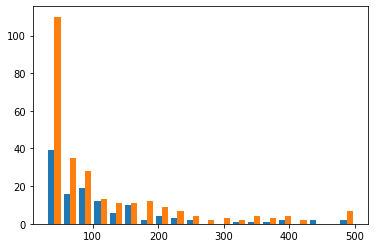

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

t1 = male_df[(male_df['treatment']==0) & (male_df['spend']!=0)]['spend']
t2 = male_df[(male_df['treatment']==1) & (male_df['spend']!=0)]['spend']
ax.hist([t1,t2], bins = 20)

## (7) セレクションバイアスのあるデータの作成
### バイアスのあるデータの作成

In [36]:
sample_rules = (male_df.history > 300) | (male_df.recency < 6) | (male_df.channel=='Multichannel')
biased_df = pd.concat([
    male_df[(sample_rules) & (male_df.treatment == 0)].sample(frac=0.5, random_state=1),
    male_df[(sample_rules) & (male_df.treatment == 1)],
    male_df[(~sample_rules) & (male_df.treatment == 0)],
    male_df[(~sample_rules) & (male_df.treatment == 1)].sample(frac=0.5, random_state=1)
], axis=0, ignore_index=True)

## (8) セレクションバイアスのあるデータで平均を比較
### groupbyを使って集計(Biased)

In [37]:
biased_df.groupby('treatment').agg( # データのグループ化
    conversion_rate=('conversion', 'mean'), # グループごとのconversionの平均
    spend_mean=('spend', 'mean'), # グループごとのspendの平均
    count=('treatment', 'count') # グループごとのデータ数
)
# 乱数でbiased_dfのデータを作成しているので数値は書籍とは異なる。（結論は変わらない）

,conversion_rate,spend_mean,count
treatment,,,
0,0.004540,0.557954,14757
1,0.013572,1.541704,17168


## (9) scipy.statsのttest_indを使ってt検定を行う(Biased)

In [38]:
## (a)男性向けメールが配信されたグループの購買データを得る
mens_mail_biased = biased_df[biased_df.treatment == 1].spend.values

## (b)メールが配信されなかったグループの購買データを得る
no_mail_biased = biased_df[biased_df.treatment == 0].spend.values

## (a)(b)の平均の差に対して有意差検定を実行
stats.ttest_ind(mens_mail_biased, no_mail_biased)

Ttest_indResult(statistic=5.595867225527975, pvalue=2.21319841336543e-08)

In [39]:
#ch2で利用するmale_df, biased_dfを保存する
joblib.dump(male_df, '../data/male_df.joblib')
joblib.dump(biased_df, '../data/biased_df.joblib')

['../data/biased_df.joblib']